
================================================================================2021-11-30 21:52:47
step1: reading data......



================================================================================2021-11-30 21:52:47
step2: setting parameters......



================================================================================2021-11-30 21:52:47
step3: training model......


[0]	train-auc:0.91533	valid-auc:0.91612
[1]	train-auc:0.92329	valid-auc:0.91886
[2]	train-auc:0.96871	valid-auc:0.96272
[3]	train-auc:0.96971	valid-auc:0.96579
[4]	train-auc:0.97116	valid-auc:0.96250
[5]	train-auc:0.97187	valid-auc:0.96557
[6]	train-auc:0.97134	valid-auc:0.96294
[7]	train-auc:0.97841	valid-auc:0.96930
[8]	train-auc:0.97752	valid-auc:0.96930
[9]	train-auc:0.97833	valid-auc:0.96930
[10]	train-auc:0.97802	valid-auc:0.96930
[11]	train-auc:0.97840	valid-auc:0.96908
[12]	train-auc:0.97938	valid-auc:0.97018
[13]	train-auc:0.97919	valid-auc:0.97829
[14]	train-auc:0.97824	valid-auc:0.97807


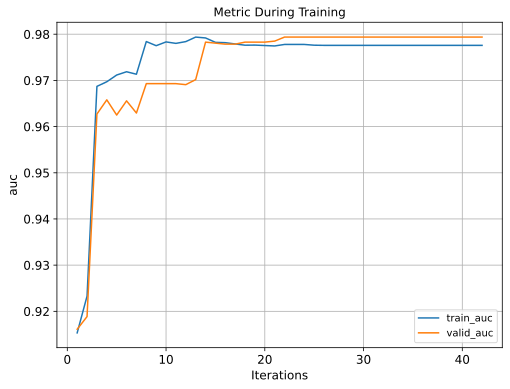

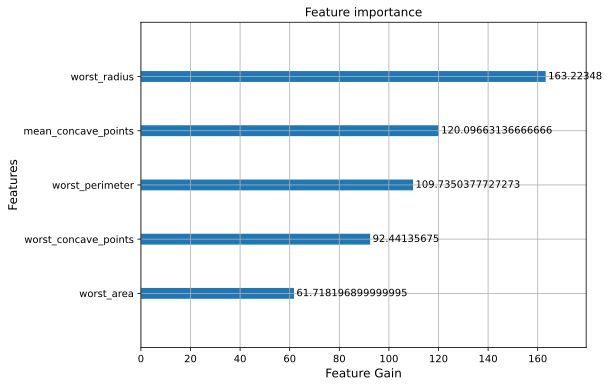

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import datetime
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def printlog(info):
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)
    print(info+'...\n\n')
    
    
#================================================================================
# 一，读取数据
#================================================================================
printlog("step1: reading data...")

# 读取dftrain,dftest
breast = datasets.load_breast_cancer()
df = pd.DataFrame(breast.data,columns = [x.replace(' ','_') for x in breast.feature_names])
df['label'] = breast.target
dftrain,dftest = train_test_split(df)

xgb_train = xgb.DMatrix(dftrain.drop("label",axis = 1),dftrain[["label"]])
xgb_valid = xgb.DMatrix(dftest.drop("label",axis = 1),dftest[["label"]])

#================================================================================
# 二，设置参数
#================================================================================
printlog("step2: setting parameters...")
                               
num_boost_round = 100                   
early_stopping_rounds = 20

# 配置xgboost模型参数
params_dict = dict()

# booster参数
params_dict['learning_rate'] = 0.05      # 学习率，通常越小越好。
params_dict['objective'] = 'binary:logistic'

# tree参数
params_dict['max_depth'] = 3              # 树的深度，通常取值在[3,10]之间
params_dict['min_child_weight']= 30       # 最小叶子节点样本权重和，越大模型越保守。
params_dict['gamma']= 0                   # 节点分裂所需的最小损失函数下降值，越大模型越保守。
params_dict['subsample']= 0.8             # 横向采样，样本采样比例，通常取值在 [0.5，1]之间 
params_dict['colsample_bytree'] = 1.0     # 纵向采样，特征采样比例，通常取值在 [0.5，1]之间 
params_dict['tree_method'] = 'hist'       # 构建树的策略,可以是auto, exact, approx, hist

# regulazation参数 
# Omega(f) = gamma*T + reg_alpha* sum(abs(wj)) + reg_lambda* sum(wj**2)  
params_dict['reg_alpha'] = 0.0            #L1 正则化项的权重系数，越大模型越保守，通常取值在[0,1]之间。
params_dict['reg_lambda'] = 1.0           #L2 正则化项的权重系数，越大模型越保守，通常取值在[1,100]之间。

# 其他参数
params_dict['eval_metric'] = 'auc'
params_dict['nthread'] = 2
params_dict['scale_pos_weight'] = 1       #不平衡样本时设定为正值可以使算法更快收敛。
params_dict['seed'] = 0


#================================================================================
# 三，训练模型
#================================================================================
printlog("step3: training model...")


result = {}
watchlist = [(xgb_train, 'train'),(xgb_valid,'valid')] 

bst = xgb.train(params = params_dict, dtrain = xgb_train, 
                num_boost_round = num_boost_round, 
                verbose_eval= 1,
                evals = watchlist,
                early_stopping_rounds=early_stopping_rounds,
                evals_result = result)


#================================================================================
# 四，评估模型
#================================================================================
printlog("step4: evaluating model ...")


y_pred_train = bst.predict(xgb_train, ntree_limit=bst.best_iteration)
y_pred_test = bst.predict(xgb_valid, ntree_limit=bst.best_iteration)

print('train accuracy: {:.5} '.format(accuracy_score(dftrain['label'], y_pred_train>0.5)))
print('valid accuracy: {:.5} \n'.format(accuracy_score(dftest['label'], y_pred_test>0.5)))

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

dfresult = pd.DataFrame({(dataset+'_'+feval): result[dataset][feval] 
               for dataset in ["train","valid"] for feval in ['auc']})

dfresult.index = range(1,len(dfresult)+1) 
ax = dfresult.plot(kind='line',figsize=(8,6),fontsize = 12,grid = True) 
ax.set_title("Metric During Training",fontsize = 12)
ax.set_xlabel("Iterations",fontsize = 12)
ax.set_ylabel("auc",fontsize = 12)


ax = xgb.plot_importance(bst,importance_type = "gain",xlabel='Feature Gain')
ax.set_xlabel("Feature Gain",fontsize = 12)
ax.set_ylabel("Features",fontsize = 12)
fig = ax.get_figure() 
fig.set_figwidth(8)
fig.set_figheight(6)

#================================================================================
# 五，保存模型
#================================================================================
printlog("step5: saving model ...")
model_dir = "model/bst.model"
print("model_dir: %s"%model_dir)
bst.save_model(model_dir)
bst_loaded = xgb.Booster(model_file=model_dir)

printlog("task end...")